In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [3]:
from torch_datasets import *

Files already downloaded and verified


In [4]:
workers = 2
batchSize = 64
imageSize = 64
nc=3
nz = 100
ngf = 64
ndf = 64
niter = 25
lr = 0.0002
beta1 = 0.5
ngpu = 1
outf = 'tutorial_samples'
root = 'celeba'
device = torch.device("cuda:0" if torch.cuda.is_available() and ngpu > 0
                      else "cpu")

random.seed(1)

In [5]:
dataset = dset.ImageFolder(root,
                           transform=transforms.Compose([
                               transforms.Resize(imageSize),
                               transforms.CenterCrop(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), 
                                                    (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=workers)

In [17]:
next(iter(dataloader))[0].shape

torch.Size([64, 3, 64, 64])

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [22]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [23]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
from utils import *

In [10]:
def train_tutorial(niter, dataloader, netD=None, netG=None):
    if not netD:
        netD = Discriminator(ngpu).to(device)
        netD.apply(weights_init)
    if not netG:
        netG = Generator(ngpu).to(device)
        netG.apply(weights_init)
    
    criterion = nn.BCELoss()

    fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
    real_label = 1
    fake_label = 0

    # setup optimizer
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    for epoch in range(niter):
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real
            netD.zero_grad()
            real_cpu = data[0].to(device)
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size,), real_label, device=device)

            output = netD(real_cpu)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
            
            if i % 500 == 0:
                print(f'\nEpoch [{epoch}/{niter}]\tMB [{i}/{len(dataloader)}]'
                      f'\nLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}'
                      f'\nD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
        
        # Save samples at end of epoch.
        fake = netG(fixed_noise)
        vutils.save_image(fake.detach(), f'{outf}/{epoch}.png', 
                          normalize=True)

        # do checkpointing
    #     torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth'
    #     torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth'
    return netD, netG

In [12]:
netD, netG = train_tutorial(1, dataloader)


Epoch [0/1]	MB [0/3166]
Loss_D: 1.4662	Loss_G: 5.8066
D(x): 0.5379	D(G(z)): 0.4687 / 0.0044

Epoch [0/1]	MB [500/3166]
Loss_D: 0.2402	Loss_G: 6.2592
D(x): 0.9290	D(G(z)): 0.1276 / 0.0040

Epoch [0/1]	MB [1000/3166]
Loss_D: 0.3867	Loss_G: 1.5812
D(x): 0.7896	D(G(z)): 0.0506 / 0.2961

Epoch [0/1]	MB [1500/3166]
Loss_D: 0.3757	Loss_G: 3.3614
D(x): 0.8190	D(G(z)): 0.1188 / 0.0585

Epoch [0/1]	MB [2000/3166]
Loss_D: 0.4634	Loss_G: 2.5704
D(x): 0.7350	D(G(z)): 0.0702 / 0.1279

Epoch [0/1]	MB [2500/3166]
Loss_D: 0.4717	Loss_G: 2.5570
D(x): 0.7322	D(G(z)): 0.0946 / 0.1110

Epoch [0/1]	MB [3000/3166]
Loss_D: 0.4586	Loss_G: 4.1119
D(x): 0.8982	D(G(z)): 0.2462 / 0.0280


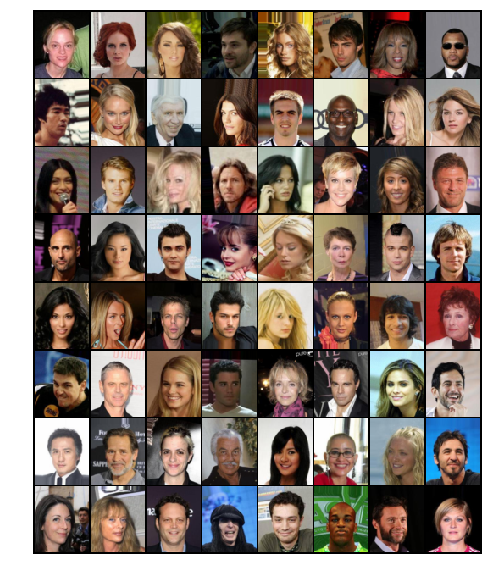

In [14]:
show_batch(celeb_dl)

In [66]:
from training import train
from models import Generator as hGenerator
from models import Discriminator as hDiscriminator

In [ ]:
d = hDiscriminator().to(device)
g = hGenerator().to(device)
train(1, d=d, g=g)